# 3.0 Results - Classifying Uncertainty

## Recap

Recall that we are trying to investigate how a new variable called Vegetation Optical Depth (VOD) compares to some of the previously used variables Land Surface Temperature (LST), Soil Moisture (SM) and Normalized Vegetation Difference Index (NDVI). The previous variables were often used to recover droughts, but studies have shown that VOD will better characterize drought conditions. So, the objective is to see how these VOD compares to other variables via information theory and other similarity measures. In addition, the data representation could make a difference in how similar VOD is to the other variables. For example, many spatial dimension or many temporal dimensions. So, we are going to look at different representations and different combinations of VOD, LST, SM, and NDVI and do comparisons.

---

#### Data

 For this first set of results, we are looking at the CONUS dataset which is located in California. We have a period of 6 years where there were drought occurences and not drought occurences.

* Droughts - 2012, 2014, 2015)
* No Drought - 2010, 2011, 2013

We have a spatial resolution of ... and a temporal resolution of 14 days.

---

#### Methods

For this first experiment, we only want to classify the expected uncertainty that each variable has with different temporal representations. So for example, we can do self-comparisons like what's the expected uncertainty of VOD with 1 temporal dimension versus 3 temporal dimensions? We will do this for all 4 variables individually. We will use RBIG to measure the expected uncertainty (aka Entropy)

$$
H(\mathbf{X}) = \mathbb{E}_\mathbf{x} \left[ -\log p(\mathbf{x}) \right]
$$

---

#### Hypothesis

Adding temporal features will definitely increase the amount of entropy within a variable. We also expect to see some differences in the entropy value obtained from the different variables. However, there should be a point where adding more temporal dimensions may not add much more information.

> We see some trend that perhaps gives us intuition that there could be a 'sweet' spot for the amount of temporal dimensions to use.

---

#### Preprocessing



1. **Climatology**

I remove the climatology because we want to characterize the anomalies outside of the climate patterns. 

2. **Similar Data**

I ensure that the lat-lon-time locations are consistent across variables. 

**Note**: We will have less samples as we increase the number of features because of the boundaries.

## Code

In [1]:
import sys
from pyprojroot import here
import pathlib
PATH = pathlib.Path(str(here()))
sys.path.append(str(here()))
# sys.path.insert(0, '/home/emmanuel/projects/2019_rbig_ad/src')
# sys.path.append('/home/emmanuel/code/py_esdc')
# sys.path.append('/home/emmanuel/code/rbig')


# DataCube PreProcessing
from scipy.io import savemat, loadmat
import geopandas as geopd
from rasterio import features

# Main Libraries
import numpy as np
import scipy.io as scio
import xarray as xr
import pandas as pd
import seaborn as sns
from datetime import date
import time

# IT Algorithms
# from rbig import RBIG, RBIGMI

# ML Preprocessing
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from scipy import signal

# Plotting
import cartopy
import cartopy.crs as ccrs

# NUMPY SETTINGS
import numpy as onp
onp.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import logging
logging.basicConfig(
    level=logging.INFO, 
    stream=sys.stdout,
    format='%(asctime)s:%(levelname)s:%(message)s'
)
logger = logging.getLogger()

# Utilities
import warnings
warnings.simplefilter('ignore', category=FutureWarning)

# Notebook Specifics
%load_ext autoreload
%autoreload 2

In [2]:
FIG_PATH = PATH.joinpath('docs/pics/entropy')
DATA_PATH = PATH.joinpath('data/drought/results/')
DATA_GROUP_PATH = PATH.joinpath('data/drought/results/compare')
FIG_GROUP_PATH = PATH.joinpath('docs/pics/droughts/lines/compare')
DATA = DATA_PATH.joinpath('exp_ind_v0.csv')

In [3]:
!ls $DATA_GROUP_PATH

drought_v0_t12_s1_c2_smadi.csv	v1_t12_s1_c2_smadi.csv


In [4]:
!ls $DATA_PATH

compare				   exp_group_v0.csv  exp_trial_v1.csv
drought_v0_t12_s1_c2.csv	   exp_group_v2.csv  group_trial_v1.csv
drought_v0_t12_s1_c2_smadi_sm.csv  exp_ind_v0.csv
drought_v0t1_s1_c2.csv		   exp_ind_v2.csv


In [5]:

datasets = [
    'exp_ind_v0.csv',
    'exp_group_v2.csv'
]

## Experiment I - Individual Variables

In [5]:
data = pd.read_csv(DATA_PATH.joinpath('exp_ind_v0.csv'), index_col=[0])
data['drought'] = np.where(data['drought'] == 1, True, False)
data.tail()

,drought,h,samples,temporal,time,variable,year
259,True,14.974458,28009.0,10.0,13.748295,LST,2015.0
260,True,15.870754,26338.0,11.0,18.317141,VOD,2015.0
261,True,12.780909,26338.0,11.0,13.455114,NDVI,2015.0
262,True,7.286896,26338.0,11.0,23.639647,SM,2015.0
263,True,16.665310,26338.0,11.0,14.535378,LST,2015.0


### Normalize

In [5]:
# normalize
data['h_norm'] = data['h'].div(data.temporal)

### Entropy

In [11]:
def plot_entropy(data, normalized=False, save=True, drought=True):
    fig, ax = plt.subplots(figsize=(7, 5))
    
    if drought == 'on':
        drought = 'drought'
        data = data[data['year'].isin([2012, 2014, 2015])]
        style = None
    elif drought == 'off':
        drought = 'nondrought'
        style = None
        data = data[data['year'].isin([2010, 2011, 2013])]
    elif drought == 'both':
        drought = 'both'
        style = 'drought'
    else:
        raise ValueError('Unrecognized drought state: ', drought)
        
        
    if normalized:
        y = 'h_norm'
        
    else:
        y = 'h'
    sns.lineplot(
        x="temporal", y=y, 
        hue='variable', 
        data=data,
        style=style,
        marker='o', 
    )
    ax.set_xlabel('Temporal Dims')
    ax.set_ylabel('Entropy')
    # plt.legend(['NDVI', 'LST', 'SM', 'VOD'])
    plt.tight_layout()
    plt.show()
#     if normalized and save:
#         fig.savefig(f"{FIG_PATH}H_norm_individual_{drought}.png", frameon=False, )
#     elif save:
    fig.savefig(FIG_PATH.joinpath(f"H_individual_{drought}.png"))
    
    

In [ ]:
 

# normalize
data['h_norm'] = data['h'].div(data.temporal)

#### Drought Years vs Non-Drought Years

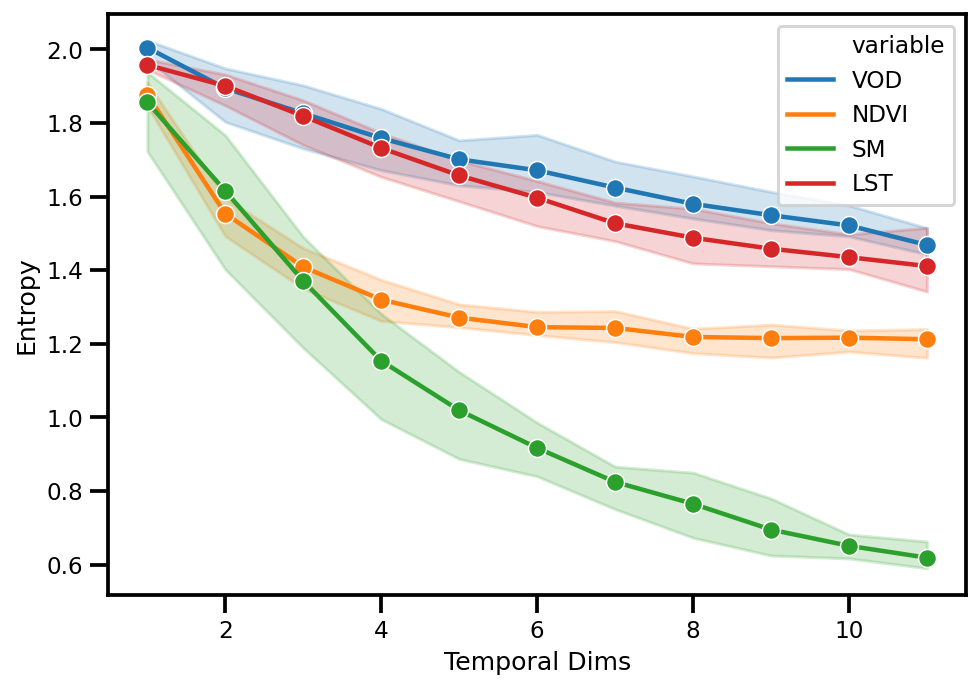

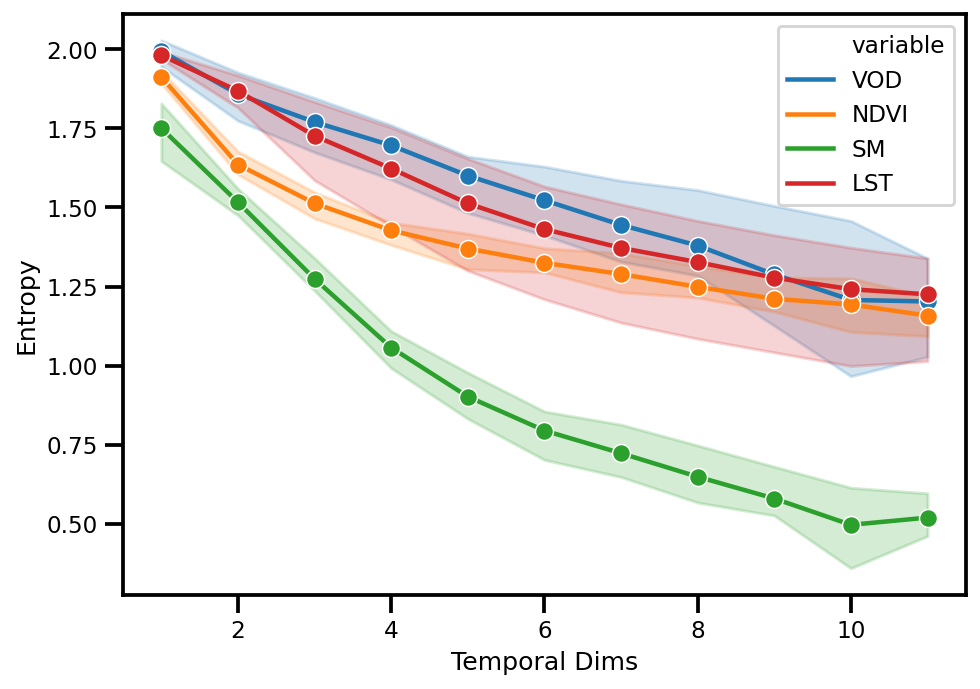

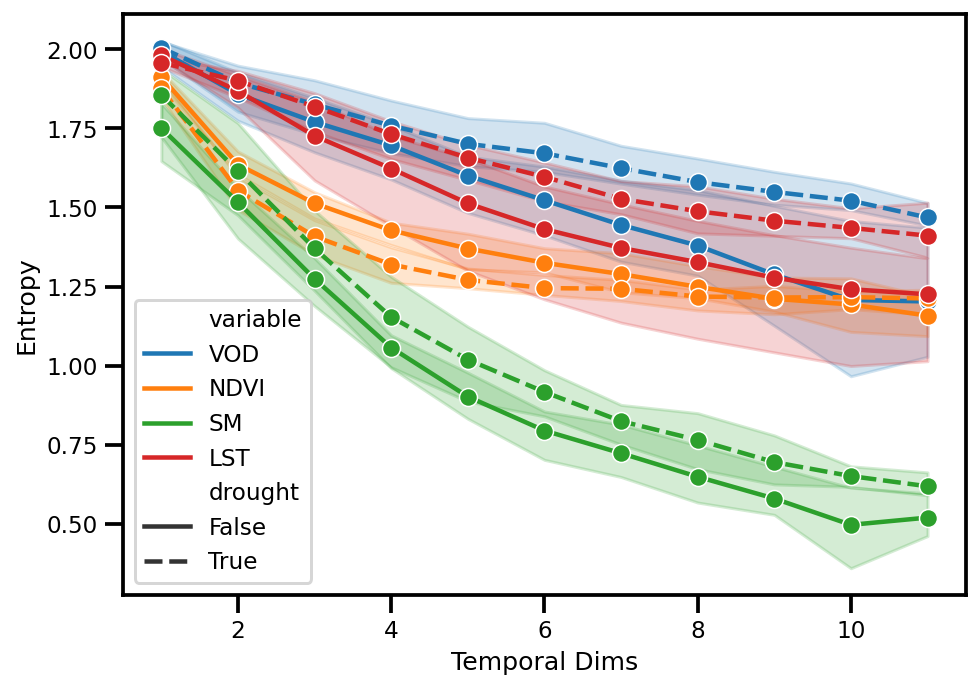

In [12]:
plot_entropy(data, normalized=True, save=False, drought='on')
plot_entropy(data, normalized=True, save=False, drought='off')
plot_entropy(data, normalized=True, save=False, drought='both')

## Experiment II - Grouped Variables

In [128]:
data.variable1.unique().tolist()

['SMADI']

In [130]:
data = pd.read_csv(DATA_GROUP_PATH.joinpath('v1_t12_s1_c2_smadi.csv'), index_col=[0])
data['drought'] = np.where(data['drought'] == 1, True, False)

# subset dataframe
cols = ['drought', 'temporal', 'rbig_H_x', 'rbig_H_y', 'variable1', 'variable2', 'year']
data = data[cols]

# data.plot(x='temporal', y='rbig_H_x')
# data.plot(x='temporal', y='rbig_H_y')
# data['rbig_H_x'] = data['rbig_H_x'] / data['temporal']
# data['rbig_H_y'] = data['rbig_H_y'] / data['temporal']
# sns.lineplot(data=data, x='temporal', y='rbig_H_x', style='drought', label='SMADI')
# sns.lineplot(data=data, x='temporal', y='rbig_H_y', style='drought', label='SMADI+')
# plt.legend(['SMADI', 'SMADI+'])
# plt.ylabel('Entropy')
# plt.xlabel('Temporal Dims')
# plt.show()

data1 = pd.melt(
    data, 
    id_vars=['drought', 'temporal', 'year'],
#     value_name='variable', 
    value_vars=['variable1', 'variable2'],
    value_name='variable',
    var_name='no'
    
).set_index(['drought', 'temporal', 'year'])
data2 = pd.melt(
    data, 
    id_vars=['drought', 'temporal', 'year'],
#     value_name='variable', 
    value_vars=['rbig_H_x', 'rbig_H_y'],
    var_name='rbig',
    value_name='h'
    
).set_index(['drought', 'temporal', 'year'])
# data1.plot(x='temporal', y='h')
# data2.plot(x='temporal', y='h')
data = pd.concat([data1, data2], axis=1).drop(columns=['rbig', 'no']).reset_index()
data.tail()

,drought,temporal,year,variable,h
139,True,8.0,2015.0,SMADI+,33.845365
140,True,9.0,2015.0,SMADI+,35.426773
141,True,10.0,2015.0,SMADI+,36.998545
142,True,11.0,2015.0,SMADI+,38.606384
143,True,12.0,2015.0,SMADI+,41.001197


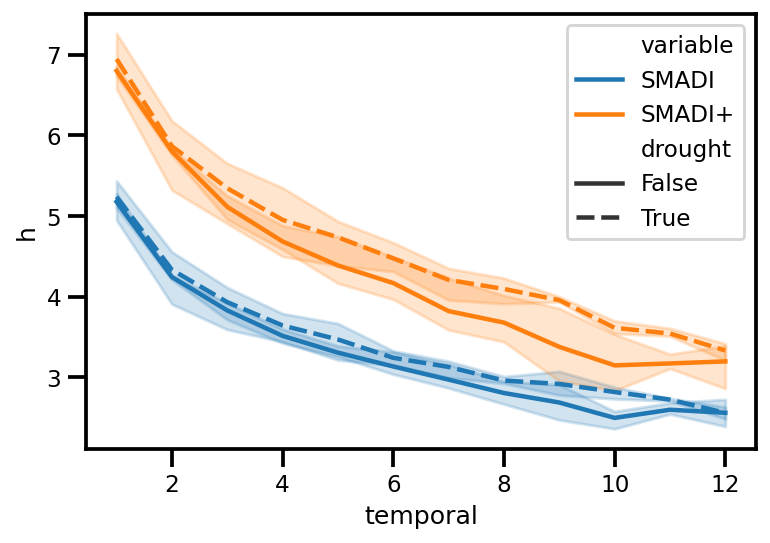

In [96]:
sns.lineplot(data=data.reset_index(), x='temporal', y='h', hue='variable', style='drought')

In [131]:
# normalize
data['h_norm'] = data['h'].div(data.temporal)

In [132]:
def plot_entropy_group(data, normalized=False, save=True, drought=True):
    fig, ax = plt.subplots(figsize=(7, 5))
    
    if drought == 'on':
        drought = 'drought'
        data = data[data['year'].isin([2012, 2014, 2015])]
        style = None
    elif drought == 'off':
        drought = 'nondrought'
        style = None
        data = data[data['year'].isin([2010, 2011, 2013])]
    elif drought == 'both':
        drought = 'both'
        style = 'drought'
    else:
        raise ValueError('Unrecognized drought state: ', drought)
        
        
    if normalized:
        y = 'h_norm'
        
    else:
        y = 'h'
    sns.lineplot(
        x="temporal", y=y, 
        hue='variable', 
        data=data,
        style=style,
        marker='o', 
    )
    ax.set_xlabel('Temporal Dims')
    ax.set_ylabel('Entropy')
    # plt.legend(['NDVI', 'LST', 'SM', 'VOD'])
    plt.tight_layout()
    plt.show()
#     if normalized and save:
#         fig.savefig(f"{FIG_PATH}H_norm_individual_{drought}.png", frameon=False, )
#     elif save:
    fig.savefig(FIG_GROUP_PATH.joinpath(f"H_grouped_{drought}.png"))
    

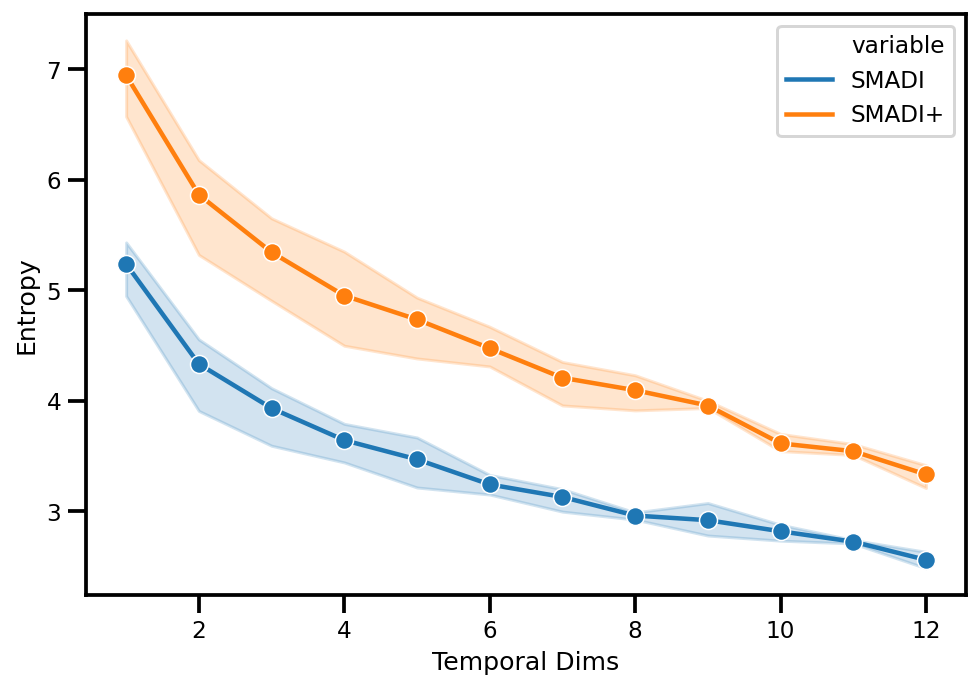

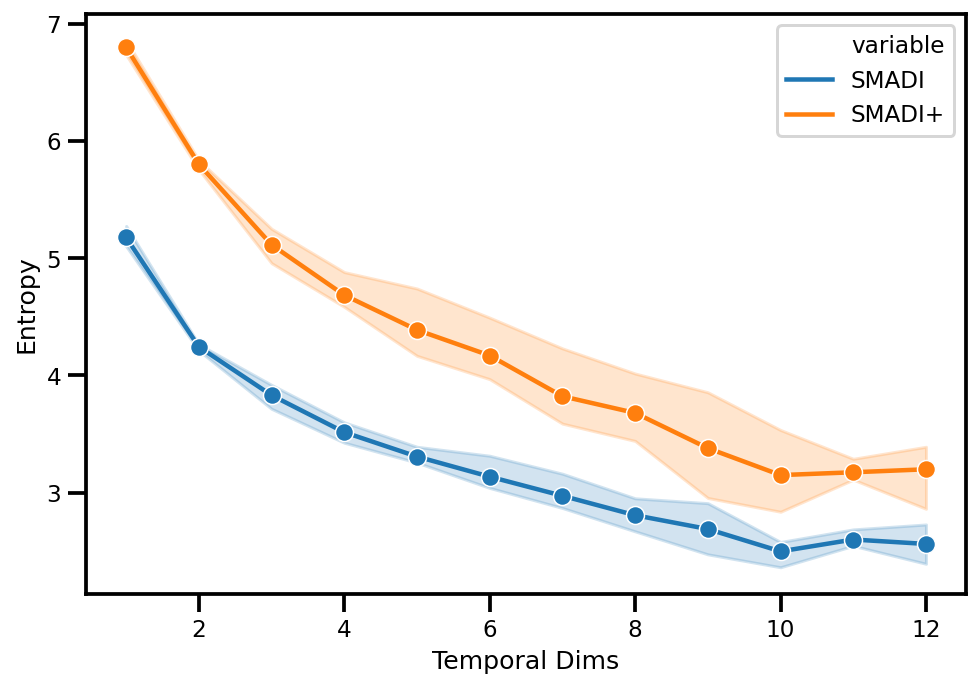

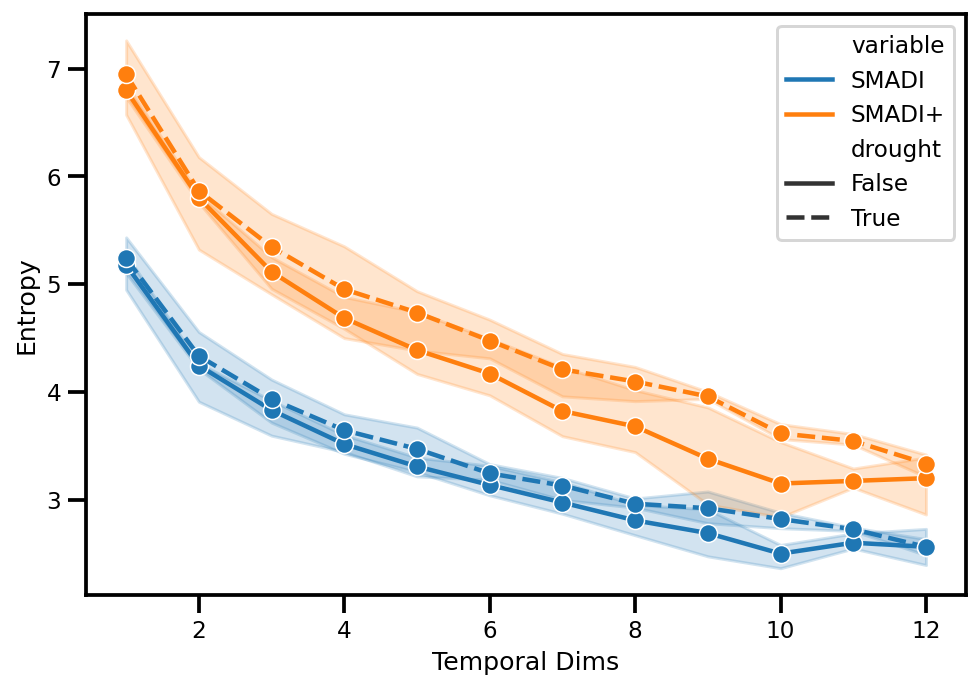

In [133]:

plot_entropy_group(data, normalized=True, save=False, drought='on')
plot_entropy_group(data, normalized=True, save=False, drought='off')
plot_entropy_group(data, normalized=True, save=False, drought='both')

## Experiment II - Comparing Variables

In [6]:
drought_v0t1_s1_c2

NameError: name 'drought_v0t1_s1_c2' is not defined

In [7]:
data_group = pd.read_csv(DATA_PATH.joinpath('drought_v0t1_s1_c2.csv'), index_col=[0])
data_group['drought'] = np.where(data_group['drought']==1, True, False)
data_group.head()

,cka_coeff,cka_x_norm,cka_xy_norm,cka_y_norm,drought,kendall,pearson,rbig_H_time,rbig_H_x,rbig_H_y,rbig_I_time,rbig_I_xx,rbig_I_xy,rbig_Ixx_time,rv_coef,samples,spearman,temporal,variable1,variable2,x_norm,xy_norm,y_norm,year
0,0.020049,2857.967075,172764.522738,3015.160538,False,0.121740,0.211504,0.740344,1.646508,1.891781,3.142588,54.408459,0.087162,4.658380,0.042068,25779.0,0.181002,1.0,LST,SM,10084.888343,4.467320e+06,10529.804294,2010.0
1,0.079700,2857.967075,702843.612344,3085.617960,False,-0.149840,-0.232198,0.740419,1.646508,1.968815,3.380640,54.408459,0.266987,4.658880,0.048041,25779.0,-0.213839,1.0,LST,NDVI,10084.888343,4.785355e+06,9877.059353,2010.0
2,0.003792,3091.911787,35349.920936,3015.160538,False,0.056306,0.064995,0.739561,2.027987,1.891781,3.126399,55.048992,0.022043,4.142112,0.005580,25779.0,0.083071,1.0,VOD,SM,10083.376387,5.924809e+05,10529.804294,2010.0
3,0.009281,3085.617960,86347.669846,3015.160538,False,-0.081360,-0.107464,0.739851,1.968815,1.891781,3.123344,54.198307,0.027839,3.681402,0.008848,25779.0,-0.118719,1.0,NDVI,SM,9877.059353,9.202224e+05,10529.804294,2010.0
4,0.008383,3085.617960,79979.840539,3091.911787,False,0.016970,0.008711,0.740168,1.968815,2.027987,3.181453,54.198307,0.033399,3.684294,0.000063,25779.0,0.024544,1.0,NDVI,VOD,9877.059353,6.274789e+03,10083.376387,2010.0


### Normalize

In [8]:
# normalize
data_group['mi_norm'] = data_group['rbig_I_xy'].div(data_group.temporal)

In [9]:
# cond1 = data_group['variable1'] == 'NDVI'
# cond2 = data_group['variable2'] == 'NDVI'
# data_group.loc[cond1 & cond2, ['variable1', 'variable2']] = data_group.loc[cond1 & cond2, ['variable2', 'variable1']].values

In [11]:
def move_variables(df: pd.DataFrame, variable: str)-> pd.DataFrame:
#     cond1 = df['variable1'] == variable
    cond = df['variable2'] == variable
    df.loc[
        cond, ['variable2', 'variable1']
    ] = df.loc[
        cond, ['variable1', 'variable2']
    ].values

    return df

In [12]:
df_new = move_variables(data_group, 'NDVI')

df_new.head()

,cka_coeff,cka_x_norm,cka_xy_norm,cka_y_norm,drought,kendall,pearson,rbig_H_time,rbig_H_x,rbig_H_y,rbig_I_time,rbig_I_xx,rbig_I_xy,rbig_Ixx_time,rv_coef,samples,spearman,temporal,variable1,variable2,x_norm,xy_norm,y_norm,year,mi_norm
0,0.020049,2857.967075,172764.522738,3015.160538,False,0.121740,0.211504,0.740344,1.646508,1.891781,3.142588,54.408459,0.087162,4.658380,0.042068,25779.0,0.181002,1.0,LST,SM,10084.888343,4.467320e+06,10529.804294,2010.0,0.087162
1,0.079700,2857.967075,702843.612344,3085.617960,False,-0.149840,-0.232198,0.740419,1.646508,1.968815,3.380640,54.408459,0.266987,4.658880,0.048041,25779.0,-0.213839,1.0,NDVI,LST,10084.888343,4.785355e+06,9877.059353,2010.0,0.266987
2,0.003792,3091.911787,35349.920936,3015.160538,False,0.056306,0.064995,0.739561,2.027987,1.891781,3.126399,55.048992,0.022043,4.142112,0.005580,25779.0,0.083071,1.0,VOD,SM,10083.376387,5.924809e+05,10529.804294,2010.0,0.022043
3,0.009281,3085.617960,86347.669846,3015.160538,False,-0.081360,-0.107464,0.739851,1.968815,1.891781,3.123344,54.198307,0.027839,3.681402,0.008848,25779.0,-0.118719,1.0,NDVI,SM,9877.059353,9.202224e+05,10529.804294,2010.0,0.027839
4,0.008383,3085.617960,79979.840539,3091.911787,False,0.016970,0.008711,0.740168,1.968815,2.027987,3.181453,54.198307,0.033399,3.684294,0.000063,25779.0,0.024544,1.0,NDVI,VOD,9877.059353,6.274789e+03,10083.376387,2010.0,0.033399


### Mutual Information

In [44]:
from typing import Optional

def plot_heatmap(df: pd.DataFrame, year: Optional[float]=None, measure: str='mi_norm') -> None:
    
    # subset df with name
    sub_df = df[['year', 'variable1', 'variable2', measure]]
    
    #
    if year is not None:
        sub_df = sub_df[sub_df['year'].isin([year])].drop('year', axis=1)
    else:
        sub_df = sub_df.groupby('variable1', 'variable2', 'year').mean('year')
        
    ssub_df = sub_df.copy()
    ssub_df[['variable1', 'variable2']] = ssub_df[['variable2', 'variable1']]
    
    sub_df = pd.concat([sub_df, ssub_df]).pivot(index='variable1', columns='variable2', values=measure)
    
    fig, ax = plt.subplots()
    sns.heatmap(sub_df, ax=ax, annot=True, cmap='Reds', vmin=0)
#     ax.invert_yaxis()
    ax.set(xlabel='', ylabel='')
    plt.tight_layout()
    plt.show()
    
    return None

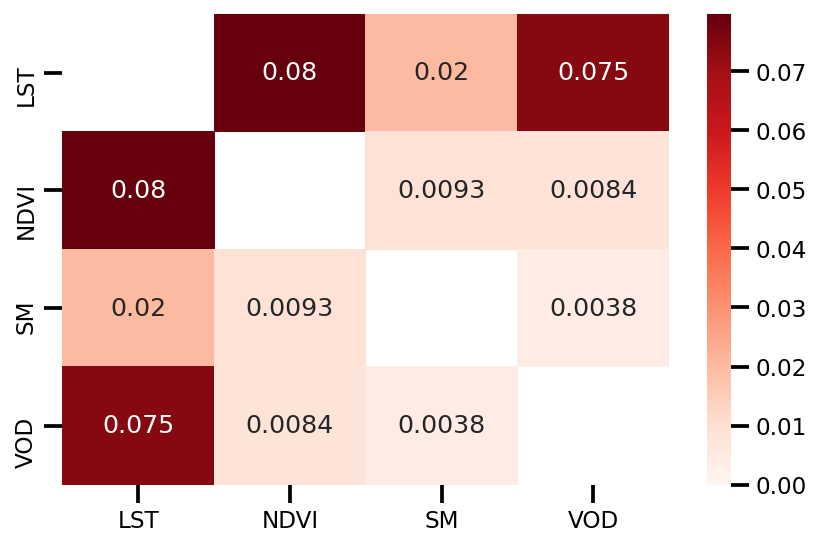

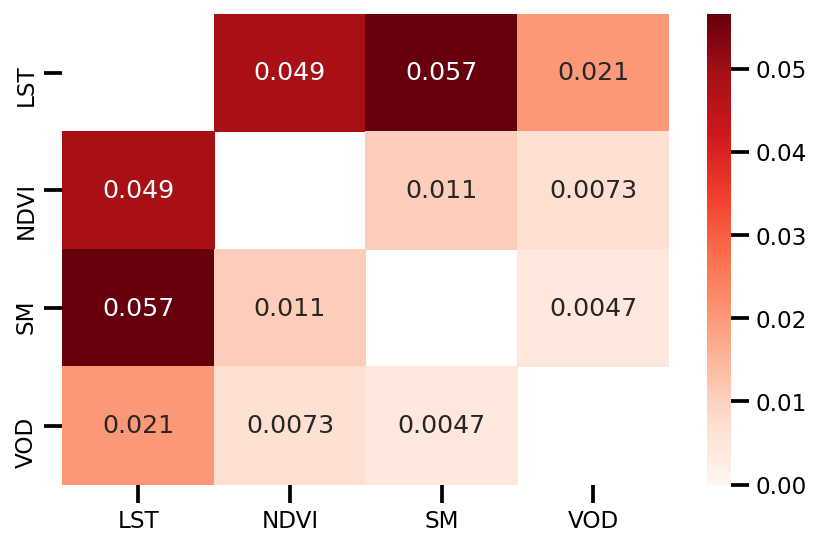

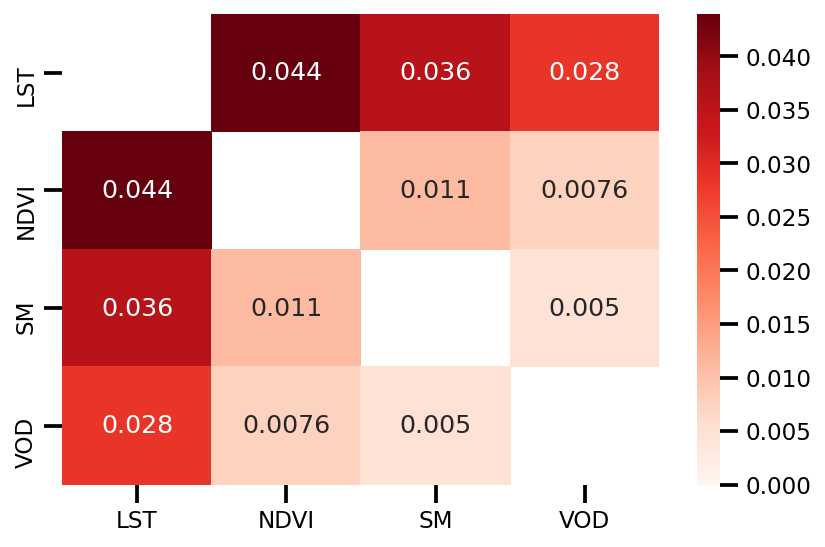

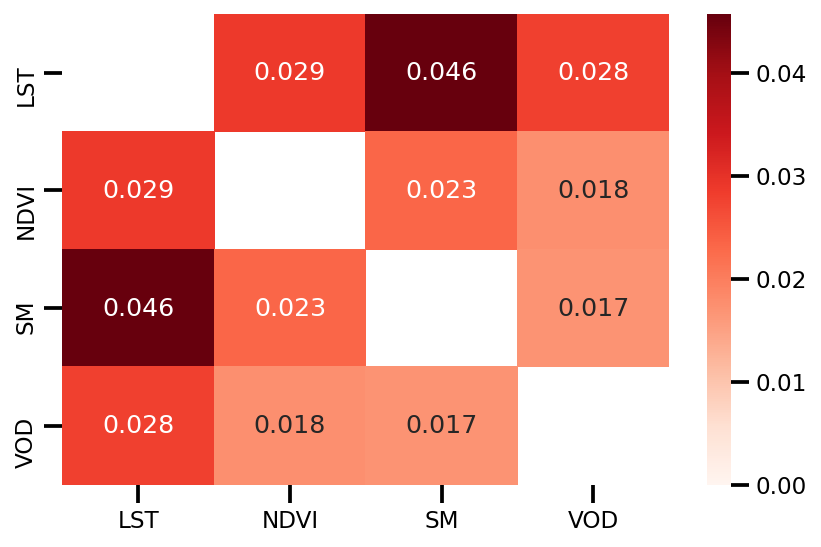

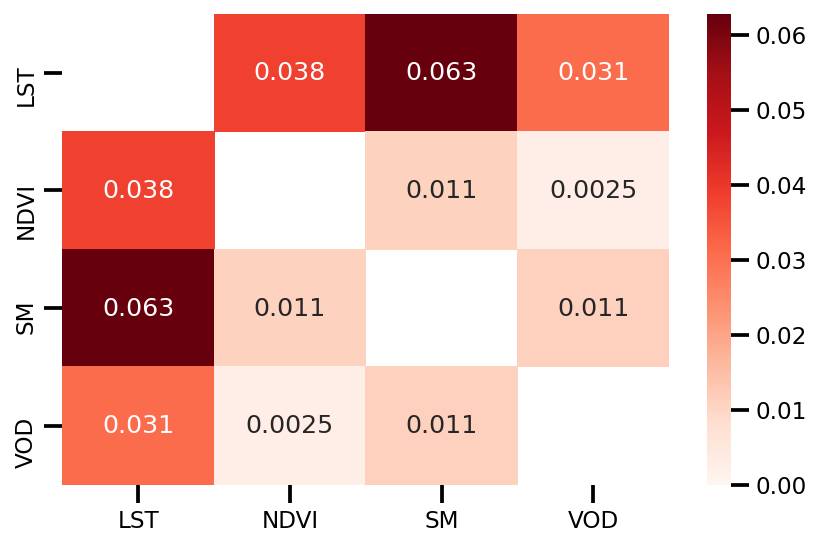

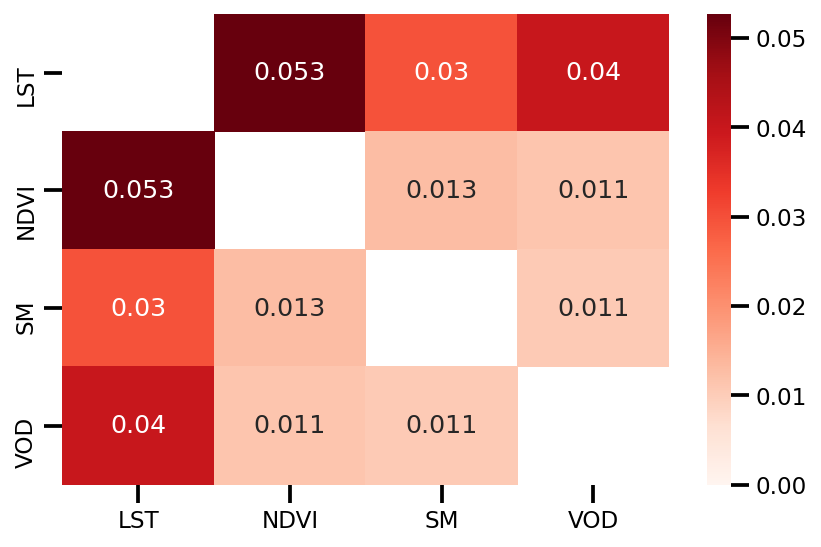

In [58]:
for iyear in [2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0]:
    plot_heatmap(df_new, iyear, 'cka_coeff')

### Experiment IV - Comparing Grouped Variables

In [14]:
data = pd.read_csv(DATA_GROUP_PATH.joinpath('v1_t12_s1_c2_smadi.csv'), index_col=[0])
data['drought'] = np.where(data['drought'] == 1, True, False)

# subset dataframe
cols = ['drought', 'temporal', 'rbig_I_xy', 'rv_coef', 'variable1', 'variable2', 'year']
data = data[cols]


# data.plot(x='temporal', y='rbig_H_x')
# data.plot(x='temporal', y='rbig_H_y')
# data['rbig_H_x'] = data['rbig_H_x'] / data['temporal']
# data['rbig_H_y'] = data['rbig_H_y'] / data['temporal']
# sns.lineplot(data=data, x='temporal', y='rbig_H_x', style='drought', label='SMADI')
# sns.lineplot(data=data, x='temporal', y='rbig_H_y', style='drought', label='SMADI+')
# plt.legend(['SMADI', 'SMADI+'])
# plt.ylabel('Entropy')
# plt.xlabel('Temporal Dims')
# plt.show()

# data = pd.melt(
#     data, 
#     id_vars=['drought', 'temporal', 'year', 'rbig_I_xy'],
# #     value_name='variable', 
#     value_vars=['variable1', 'variable2'],
#     value_name='variable',
#     var_name='no'
    
# ).drop(columns=['no']).reset_index()
# data1.plot(x='temporal', y='h')
# data2.plot(x='temporal', y='h')
# data = pd.concat([data1, data2], axis=1)
data.tail()

,drought,temporal,rbig_I_xy,rv_coef,variable1,variable2,year
67,True,8.0,39.635912,0.901904,SMADI,SMADI+,2015.0
68,True,9.0,39.784822,0.902987,SMADI,SMADI+,2015.0
69,True,10.0,41.570516,0.904695,SMADI,SMADI+,2015.0
70,True,11.0,53.638460,0.904877,SMADI,SMADI+,2015.0
71,True,12.0,62.999866,0.907876,SMADI,SMADI+,2015.0


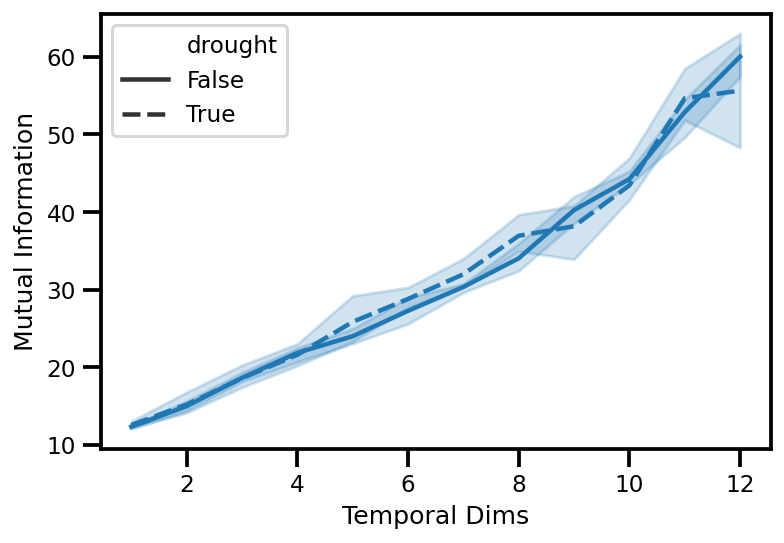

In [11]:
plt.figure()
sns.lineplot(data=data.reset_index(), x='temporal', y='rbig_I_xy', style='drought')
plt.xlabel('Temporal Dims')
plt.ylabel('Mutual Information')
plt.savefig(FIG_GROUP_PATH.joinpath(f"MI_grouped_drought.png"))
plt.show()

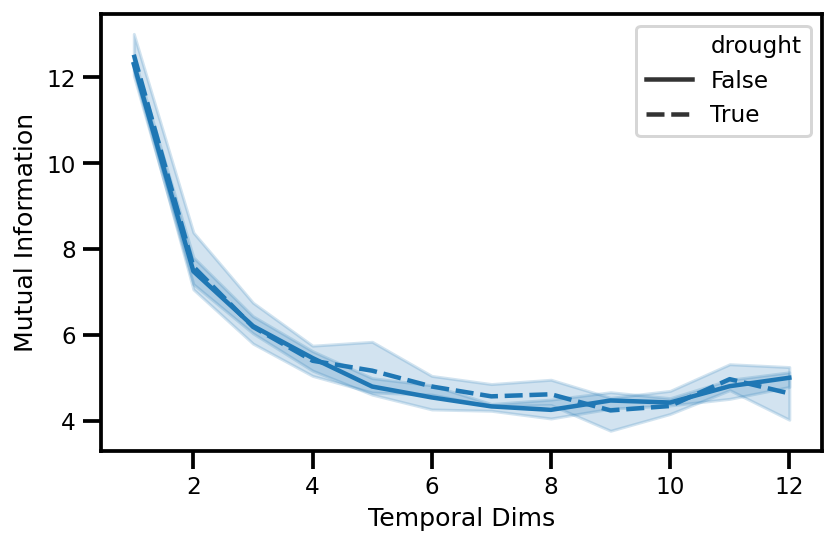

In [19]:

data['I_xy_norm'] = data['rbig_I_xy'] / data['temporal']

sns.lineplot(data=data.reset_index(), x='temporal', y='I_xy_norm', style='drought')
plt.xlabel('Temporal Dims')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.savefig(FIG_GROUP_PATH.joinpath(f"MIn_grouped_drought.png"))
plt.show()

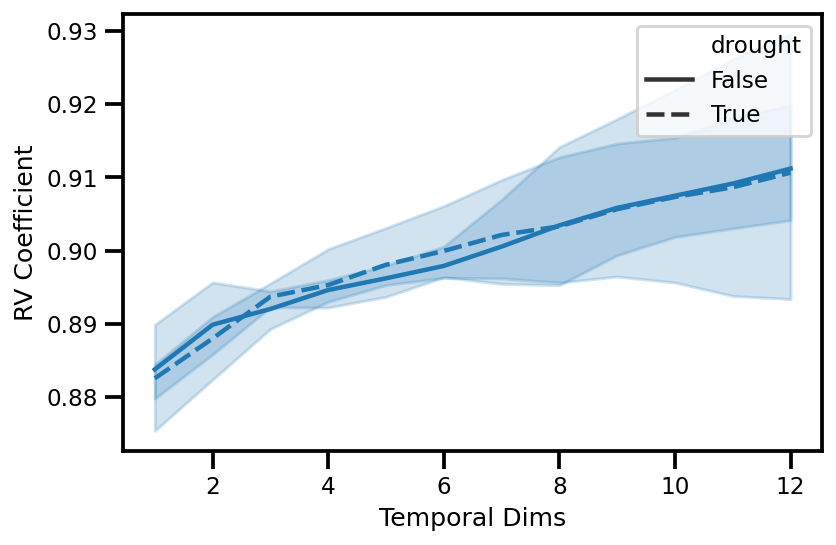

In [18]:
sns.lineplot(data=data.reset_index(), x='temporal', y='rv_coef', style='drought')
plt.xlabel('Temporal Dims')
plt.ylabel('RV Coefficient')
plt.tight_layout()
plt.savefig(FIG_GROUP_PATH.joinpath(f"RV_grouped_drought.png"))
plt.show()

In [ ]:

data['I_xy_norm'] = data['rbig_I_xy'] / data['temporal']

sns.lineplot(data=data.reset_index(), x='temporal', y='I_xy_norm', style='drought')
plt.xlabel('Temporal Dims')
plt.ylabel('Mutual Information')
plt.savefig(FIG_GROUP_PATH.joinpath(f"MIn_grouped_drought.png"))
plt.show()

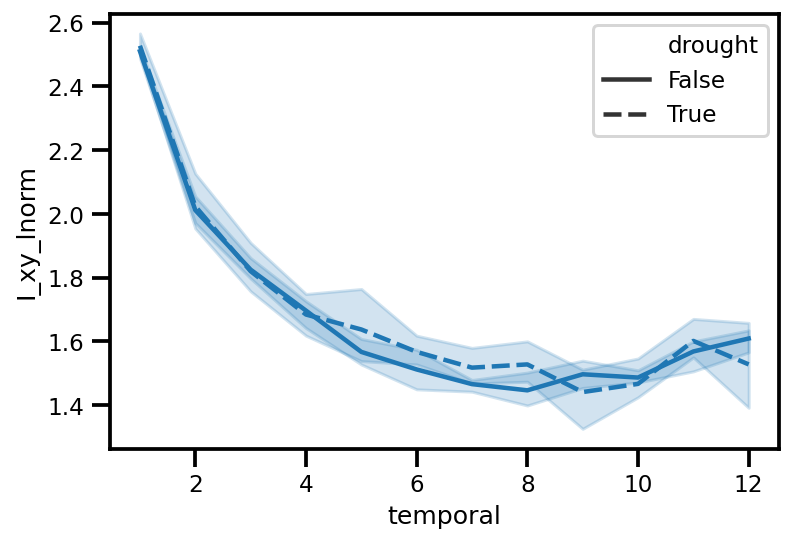

In [122]:
data['I_xy_lnorm'] = np.log(data['rbig_I_xy'] / data['temporal'])

sns.lineplot(data=data.reset_index(), x='temporal', y='I_xy_lnorm', style='drought')
plt.xlabel('Temporal Dims')
plt.ylabel('Mutual Information')
plt.savefig(FIG_GROUP_PATH.joinpath(f"MIn_grouped_drought.png"))
plt.show()

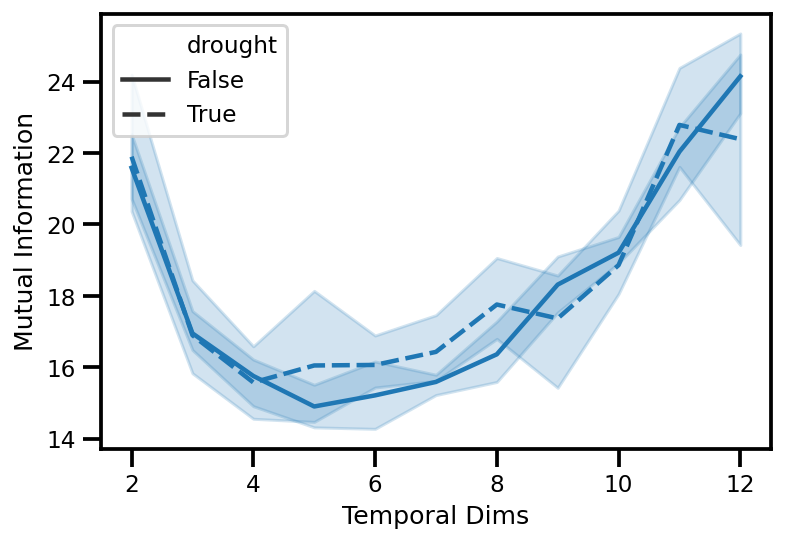

In [138]:
data['I_xy_lnorm'] = data['rbig_I_xy'] / np.log(data['temporal'])

sns.lineplot(data=data.reset_index(), x='temporal', y='I_xy_lnorm', style='drought')
plt.xlabel('Temporal Dims')
plt.ylabel('Mutual Information')
plt.savefig(FIG_GROUP_PATH.joinpath(f"MI_ln_grouped_drought.png"))
plt.show()

In [119]:
np.log(np.arange(1,12+1))

array([0.   , 0.693, 1.099, 1.386, 1.609, 1.792, 1.946, 2.079, 2.197,
       2.303, 2.398, 2.485])

#### RV Coefficient

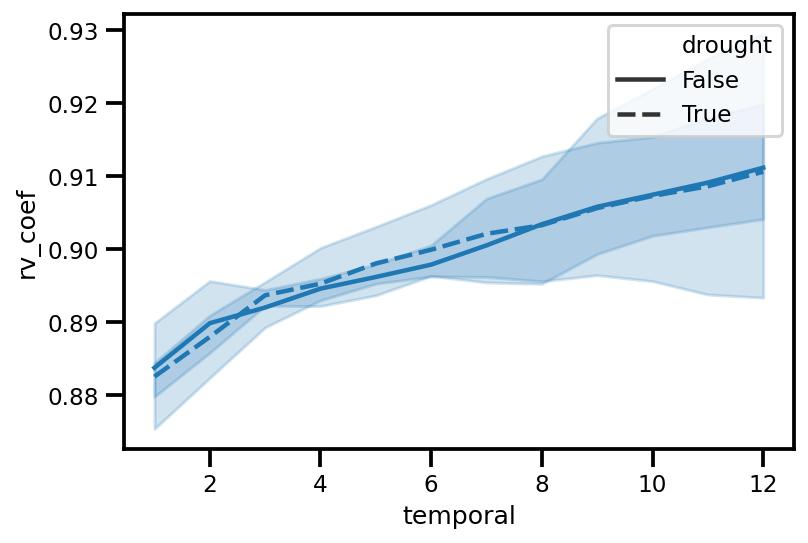

In [126]:
sns.lineplot(data=data.reset_index(), x='temporal', y='rv_coef', style='drought')